# Regularization

Imposing certain limitations on the regression coefficients making the model more resistent to overfitting

## Example 1. Regularization with artifical data

In [1]:
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf
import statsmodels.api as sm
from sklearn import linear_model
import matplotlib.pylab as plt
import math
import seaborn as sbn
from sklearn.metrics import r2_score
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [2]:
#Find the Alpha and report best test performance for Ridge/Lasso.
def Regularization_fit_alpha(model,X_train,y_train,X_valid,y_valid,alphas,Graph=False, logl=False):
    #model = 1-Ridge, 2-Lasso
    #aplhas: a list of aplha values to try
    #Graph: plot the graph of R^2 values for different alpha

    R_2_OS=[] #out of sample R2's
    
    #initialize the model to use for each given alpha
    if model==1:
        RM = lambda a: linear_model.Ridge(fit_intercept=True, alpha=a)
        model_label='Ridge'
    else:
        RM = lambda a: linear_model.Lasso(fit_intercept=True, alpha=a)
        model_label='Lasso'
    
    best_R2 = -1
    best_alpha = alphas[0]
    best_coefs = []
    
    for a in alphas: #for all alphas to try
        lm = RM(a) #assign the model
        lm.fit(X_train,y_train)  #fit the regularization model
        y_predict=lm.predict(X_valid) #compute the prediction for the validation sample 
        R_2_OS_=r2_score(y_valid,y_predict)
        R_2_OS.append(R_2_OS_)
        if R_2_OS_ > best_R2: #if current OS R2 is the best - update the best solution
            best_R2 = R_2_OS_
            best_alpha = a
            best_coefs = lm.coef_
    
    if Graph==True: #visualization of the performance depending on alpha
        plt.title('OS-R-squared for different Alpha')
        if logl: #log-scale
            plt.xlabel('ln(Alpha)')
            l=np.log(alphas)
            bl=np.log(best_alpha)
        else:
            plt.xlabel('Alpha')
            l=alphas
            bl=best_alpha
        plt.ylim((-0.1,1))
        plt.plot(l,R_2_OS,'b',label=model_label)
        plt.legend(loc='upper right')
        plt.ylabel('R-squared')
        plt.axvline(bl,color='r',linestyle='--')

        plt.show()
    
    return [best_alpha,best_R2,best_coefs]

In [3]:
#generate random data repeating regressors with minor fluctuations
M = 20 #size of the training, validation and test samples
np.random.seed(1)

X = pd.DataFrame(np.random.randn(3*M,3)) #observstions for three random input variables (features)
Y = X.sum(axis = 1) + np.random.randn(3*M) #add a target variable as a sum of the three features and some noise
data = pd.concat([Y,X]+[X+0.01*np.random.randn(3*M,3) for i in range(4)], axis = 1)  # add four duplicates of the features with minor noise and stack Y and X into a single dataframe
data.columns = ['Y'] + ['x%d'%(i+1) for i in range(data.shape[1]-1)]         # name the columns
#split into training, test and validation sets
dataTrain=data.iloc[:M,:]
dataTest=data.iloc[M:2*M,:]
dataValid=data.iloc[2*M:,:]

In [4]:
dataTrain.head() #training data structure (15 features)

,Y,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,x11,x12,x13,x14,x15
0,-0.788142,1.624345,-0.611756,-0.528172,1.619363,-0.614866,-0.528191,1.622058,-0.595623,-0.531920,1.613616,-0.606805,-0.537692,1.631123,-0.622822,-0.531764
1,-2.195552,-1.072969,0.865408,-2.301539,-1.086935,0.856794,-2.294792,-1.080468,0.885954,-2.301005,-1.078150,0.850794,-2.306702,-1.067915,0.877587,-2.320946
2,1.805829,1.744812,-0.761207,0.319039,1.750997,-0.765639,0.337144,1.740020,-0.757705,0.319211,1.748323,-0.761895,0.305561,1.736750,-0.760716,0.313078
3,0.445823,-0.249370,1.462108,-2.060141,-0.262428,1.458658,-2.062449,-0.253662,1.474193,-2.048984,-0.234663,1.465480,-2.050060,-0.240754,1.441244,-2.056523
4,0.316851,-0.322417,-0.384054,1.133769,-0.350348,-0.364679,1.137433,-0.314009,-0.385083,1.145238,-0.314565,-0.390703,1.114319,-0.318158,-0.383564,1.144792


In [5]:
#perform a regression of the target variable against those three features we used to compute it
lm = smf.ols(formula = 'Y ~ x1+x2+x3', data = dataTrain).fit()
OLS_coef=lm.params
print(lm.summary())

                            OLS Regression Results                            
Dep. Variable:                      Y   R-squared:                       0.769
Model:                            OLS   Adj. R-squared:                  0.726
Method:                 Least Squares   F-statistic:                     17.79
Date:                Sun, 26 Dec 2021   Prob (F-statistic):           2.38e-05
Time:                        08:58:20   Log-Likelihood:                -23.431
No. Observations:                  20   AIC:                             54.86
Df Residuals:                      16   BIC:                             58.84
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.3465      0.197      1.757      0.0

R2 is somewhat high and the coefficient estimates are relatively close to the original ones we used - confidence intervals include 1; some deviations might be attributed to adding substantial noise to the target variable

Can we do better if we add other features? Although we know they are random and target variable has little to do with them...

In [6]:
#now perform the regression over all the 15 features including noisy duplicates
#use "join" to engineer a string regression formulae, stacking together feature names adding '+' in between
lm2 = smf.ols(formula = 'Y ~ '+ '+'.join(dataTrain.columns[1:]), data = dataTrain).fit()
OLS_coef=lm2.params
print(lm2.summary())

                            OLS Regression Results                            
Dep. Variable:                      Y   R-squared:                       0.933
Model:                            OLS   Adj. R-squared:                  0.682
Method:                 Least Squares   F-statistic:                     3.715
Date:                Sun, 26 Dec 2021   Prob (F-statistic):              0.107
Time:                        08:58:20   Log-Likelihood:                -11.065
No. Observations:                  20   AIC:                             54.13
Df Residuals:                       4   BIC:                             70.06
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.1937      0.608      0.318      0.7

R2 increased, but neither p-value nor coefficient estimates make much sense now.

Perfect case of multicollinearity and likely overfitting!

In [8]:
#indeed the test R2 is negative this way
r2_score(dataTest.Y,lm2.predict(dataTest))

-0.892708496099861

How can we see from the regression itself that smth is wrong? Let's look at the coefficients having pretty hight magnitude compared to the original scale of the data

In [9]:
lm2.params

Intercept      0.193676
x1            -9.263060
x2           -32.409580
x3          -134.625216
x4           -11.160992
x5           -21.131152
x6           102.037978
x7           -25.407631
x8             4.826498
x9           -40.708135
x10           12.981378
x11           64.225496
x12           36.458027
x13           33.259082
x14          -14.292609
x15           37.977691
dtype: float64

# Idea of regularization

When fitting a linear regression with multiple features $x=(x^1,x^2,...,x^n)$ 
$$
y\sim w^T x
$$
the model might become complex and susceptible to overfitting. Complexity often comes with coefficients $w$ growing large in absolute values.

One way to reduce complexity is to penalize regression for the magnitude of the coefficients $w=(w^1,w^2,...,w^n)$, which can be measured by
$$
||w||_1=\sum\limits_j |w^j|
$$
or by 
$$
||w||_2^2=\sum\limits_j (w^j)^2
$$
So instead of simply minimizing 
$$
RSS(w)=\sum\limits_j (y_j-w^T x_j)^2
$$
where $x_j, y_j$ are observations for regressors and output variable, we minimize
$$
RSS(w)+\lambda ||w||_2^2=RSS(w)+\lambda \sum\limits_j (w^j)^2\to\min\hspace{10ex}(Ridge)
$$
or
$$
RSS(w)+\lambda ||w||_1=RSS(w)+\lambda \sum\limits_j \left|w^j\right|\to\min\hspace{10ex}(Lasso)
$$

The first model is known as Ridge, the second - as Lasso (least absolute shrinkage and selection operator) regularized regression.

Both Ridge and Lasso could be shown to be equivalent to a constrained minimization of $RSS$:

$$
RSS(w)\to min, \ ||w||_p\leq \alpha,
$$

with $p=1,2$ respectively, although analytic relation between constants $\alpha$ and $\lambda$ is somewhat nontrivial. In practice however the choice of $\lambda$ or $\alpha$ is usually empirical anyway, so both regularized or constrained forms of the optimization problem are equally applicable.

Optimization problems (Ridge) and (Lasso) tend to minimize $RSS$ at the same time penalizing the regression for having $||w||$ too large (regularization) which often leads to the model complexity through multiple regressors with large coefficients canceling effect of each other. So in a sense Lasso and Ridge are trying to avoid this situation, looking for relatively simple "regular" models with best possible fit. 

** NOTICE ** As the order of magnitude of $w^j$ is directly related to the scale of the regressors, it is practical to rescale them (e.g. by standardizing) to make sure the $w^j$ are comparable in scale. Otherwise penalization terms directly mixing components $w^j$ of different, sometimes incomparable, scale do not make too much sense.

From Bayesian standpoint (for those familiar with Bayesian inference) Lasso and Ridge simply perform the regression with the prior belief that all the components of the $w$ are limited through the fixed variance of the priors. Such a belief affects the final outcome of the model making solutions with large $||w||$ to be particularly unlikely.

This helps Ridge and Lasso to fight overfitting also dealing with multicollinearity of regressors to some extent, preventing from learning noise through particularly complex "unnatural" combinations of the regressors.

Ridge regression admits solution in the closed form (consider partial derivatives of the objective function with respect to $w_j$):

$$
\hat{w}=(X^T X+\lambda I)^{-1}X^T Y, \hspace{5ex}(Ridge\ solution)
$$

where $I$ is the identity $n\times n$ matrix, while $n$ being the number of regressors. The formulae (Ridge solution) shows that the Ridge regression can in theory deal with the case of multicollinearity, when the matrix $X^T X$ is singular and OLS estimate does not exist.

Lasso does not admit solution in the closed form and requires numerical methods (like subgradient methods) to be fit. 
Lasso however has an advantage of being often able to completely eliminate impact of certain irrelevant regressors setting the corresponding slope coefficients to zero.  

### Validation and cross-validation

A good way to evaluate the model is to use a test set separate from the training sample to estimate the model performance. Additionally if the model depends on the certain parameters (like $\alpha,\lambda$ for Lasso/Ridge) which are not supposed to be fit during the training phase, a separate validation sample could be used for the selection of model parameters (we pick up those which optimize model performance over the validation set). Usually test and validation sets are got as subsamples (often random) of the available dataset, while the remaining data is used as the training sample. 

But often the available dataset is small enough, so splitting into into even smaller traning, validation and test sets could have negative impact on the model training leading to noisy and unreliable models. In such cases cross-validation is often applied, performing not one but several random splits of the sample with further averaging of the model performance scores. 

## Choice of $\lambda$ or $\alpha$. Model validation.

In both - constrained and regularized forms - the parameter $\alpha$ or $\lambda$ of Lasso/Ridge regression is somewhat arbitrary and can take any value from $0$ to $+\infty$. Small values of $\lambda$ or high values of $\alpha$ lead to the result close to OLS (identical to it is $\lambda=0$ or $\alpha=+\infty$), while large $\lambda$ or small $\alpha$ tend to overemphasize the impact of regularization over the fit itself. There is no single best way of choosing the value of the regularization parameter - what is usually suggested is to fit it by evaluating the model for different values of the parameter over the separate validation set and picking up the value for which the validation performance is the best one. As for the performance metric one can use RSS or, equivalently, R2.

In [10]:
#try Ridge with an arbitrary regularization parameter alpha=1
Ridge=linear_model.Ridge(fit_intercept=True, alpha=1)
Ridge.fit(dataTrain.iloc[:,1:],dataTrain.Y)
# In sample:
YPred_IS=Ridge.predict(dataTrain.iloc[:,1:])
print("The IS R-squared of Ridge is: {0}".format(r2_score(dataTrain.Y,YPred_IS)))
Ridge.coef_

The IS R-squared of Ridge is: 0.769666378885421


array([0.1896624 , 0.24722858, 0.18132605, 0.21763589, 0.24170847,
       0.17970417, 0.15691973, 0.22943271, 0.11503989, 0.19477322,
       0.28970272, 0.23323684, 0.19730613, 0.2294736 , 0.19280885])

In [11]:
#Out of sample
YPred_OS=Ridge.predict(dataTest.iloc[:,1:])
print("The OS R-squared of Ridge is: {0}".format(r2_score(dataTest.Y,YPred_OS)))

The OS R-squared of Ridge is: 0.34311698518509703


In [12]:
#try Lasso with an another arbitrary regularization parameter alpha=0.01 (if we try alpha=1 this turns out to be too much regularization already)
Lasso=linear_model.Lasso(fit_intercept=True, alpha=0.1)

Lasso.fit(dataTrain.iloc[:,1:],dataTrain.Y)
# In sample:
YPred_IS=Lasso.predict(dataTrain.iloc[:,1:])
print("The IS R-squared of Lasso is: {0}".format(r2_score(dataTrain.Y,YPred_IS)))
#Out of sample
YPred_OS=Lasso.predict(dataTest.iloc[:,1:])
print("The OS R-squared of Lasso is: {0}".format(r2_score(dataTest.Y,YPred_OS)))
Lasso.coef_

The IS R-squared of Lasso is: 0.7545180291370723
The OS R-squared of Lasso is: 0.4163229478498718


array([0.        , 0.        , 0.        , 0.80668997, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       1.02567708, 0.81067886, 0.        , 0.        , 0.        ])

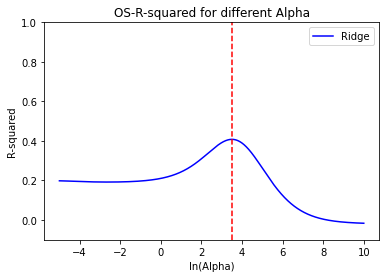

Optimal alpha for Ridge=33.16019248594952, best OS R_2=0.4081703394189098


In [13]:
alphas = np.exp(np.linspace(-5,10,10000)) #exponential range of possible alphas
[alpha_optimal, best_R2, best_coefs]=Regularization_fit_alpha(1,dataTrain.iloc[:,1:],dataTrain.Y,dataValid.iloc[:,1:],dataValid.Y,alphas,Graph=True,logl=True)
print('Optimal alpha for Ridge={0}, best OS R_2={1}'.format(alpha_optimal,best_R2))

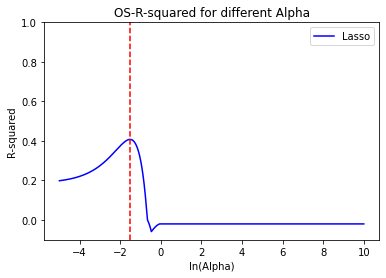

Optimal alpha for Lasso=0.21878801954843707, best OS R_2=0.40797693181670136


In [14]:
alphas = np.exp(np.linspace(-5,10,10000)) #exponential range of possible alphas
[alpha_optimal, best_R2, best_coefs]=Regularization_fit_alpha(2,dataTrain.iloc[:,1:],dataTrain.Y,dataValid.iloc[:,1:],dataValid.Y,alphas,Graph=True,logl=True)
print('Optimal alpha for Lasso={0}, best OS R_2={1}'.format(alpha_optimal,best_R2))

In [15]:
#now consider the test sample performanc of the best Lasso model and its coefficients

In [16]:
Lasso=linear_model.Lasso(fit_intercept=True, alpha=alpha_optimal)

Lasso.fit(dataTrain.iloc[:,1:],dataTrain.Y)
# In sample:
YPred_IS=Lasso.predict(dataTrain.iloc[:,1:])
print("The IS R-squared of Lasso is: {0}".format(r2_score(dataTrain.Y,YPred_IS)))
#Out of sample
YPred_OS=Lasso.predict(dataTest.iloc[:,1:])
print("The OS R-squared of Lasso is: {0}".format(r2_score(dataTest.Y,YPred_OS)))
Lasso.coef_

The IS R-squared of Lasso is: 0.6798581736149641
The OS R-squared of Lasso is: 0.4519368356541287


array([0.        , 0.        , 0.        , 0.41519791, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.72985833, 0.68059909, 0.19852351, 0.        , 0.        ])

## Homework
Recall the polynomial regression from previous class and try lasso for degree selection.

First recreate the data

In [17]:
#generate data and put it in the dataframe
np.random.seed(2018)
x=np.arange(-10,20,0.5)
y=x**4/100+x**3/20+x**2/3+2*x+np.random.normal(loc=0,scale=3,size=60)
data2=pd.DataFrame({'x':x,'y':y}) #create adataframe
#slice the data in three pieces (we'll talk about those later)
data2.head() #for now let's stick with this first one

,x,y
0,-10.0,62.503031
1,-9.5,51.410761
2,-9.0,44.605198
3,-8.5,24.739247
4,-8.0,22.200164


In [18]:
data2 = data2.reindex(['y','x'], axis=1)

In [19]:
M=10
for p in range(2,M+1): #add more powers of x up to 10'th
    data2['x%d'%p]=data2.x**p
data2.head()

,y,x,x2,x3,x4,x5,x6,x7,x8,x9,x10
0,62.503031,-10.0,100.00,-1000.000,10000.0000,-100000.00000,1000000.000000,-1.000000e+07,1.000000e+08,-1.000000e+09,1.000000e+10
1,51.410761,-9.5,90.25,-857.375,8145.0625,-77378.09375,735091.890625,-6.983373e+06,6.634204e+07,-6.302494e+08,5.987369e+09
2,44.605198,-9.0,81.00,-729.000,6561.0000,-59049.00000,531441.000000,-4.782969e+06,4.304672e+07,-3.874205e+08,3.486784e+09
3,24.739247,-8.5,72.25,-614.125,5220.0625,-44370.53125,377149.515625,-3.205771e+06,2.724905e+07,-2.316169e+08,1.968744e+09
4,22.200164,-8.0,64.00,-512.000,4096.0000,-32768.00000,262144.000000,-2.097152e+06,1.677722e+07,-1.342177e+08,1.073742e+09


In [22]:
data2_Valid=data2.loc[40:49]
data2_Test=data2.loc[50:59]
data2_Train=data2.loc[0:39] 

<span style="color:red; font-size:18pt"> This is degree selection, if it is not required, just comment it. Thank you!</span>

In [23]:
# TrainR2=[0]*10
# ValidR2=[0]*10
# lm=[0]*10
# for M in range(1,11):
#     formula='y~x'+'+'*(M>1)+'+'.join(['x%d'%p for p in range(2,M+1)]);
#     lm[M-1] = smf.ols(formula=formula, data =data2_Train).fit()
#     data2_Valid['ypred']=lm[M-1].predict(data2_Valid)
#     ValidR2[M-1]=1-((data2_Valid.ypred-data2_Valid.y)**2).sum()/((data2_Valid.y-data2_Valid.y.mean())**2).sum()
#     TrainR2[M-1]=lm[M-1].rsquared
# M=np.argmax(ValidR2)+1
# data2 = data2.iloc[:, :M+1]
# data2_Valid=data2.loc[40:49]
# data2_Test=data2.loc[50:59]
# data2_Train=data2.loc[0:39] 

### Q1 First try the model with a single alpha = 1. Assess the model performance over the test set


In [24]:
Lasso=linear_model.Lasso(fit_intercept=True, alpha=1)
Lasso.fit(data2_Train.iloc[:,1:],data2_Train.y)
# In sample:
YPred_IS=Lasso.predict(data2_Train.iloc[:,1:])
print("The IS R-squared of Lasso is: {0}".format(r2_score(data2_Train.y,YPred_IS)))

The IS R-squared of Lasso is: 0.9967458686352152


In [25]:
#Out of sample
YPred_OS=Lasso.predict(data2_Test.iloc[:,1:])
print("The OS R-squared of Lasso is: {0}".format(r2_score(data2_Test.y,YPred_OS)))

The OS R-squared of Lasso is: -1042.995469549362


<span style='font-size:18pt; color:red'>Test set R2 score is low</span>

### Q2 Next perform hyperparameter selection over the validation set. Assess the resulting model.
Find the best alpha from np.linspace(-10,10,200) maximizing the validation R2. Assess the performance of the model with the best alpha over the test set 

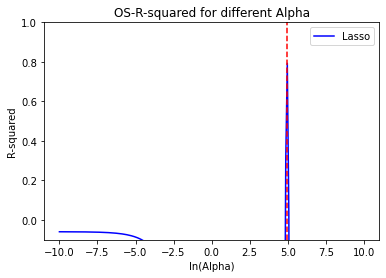

Optimal alpha for Lasso=144.73064176460485, best OS R_2=0.7928221820059637


In [26]:
alphas = np.exp(np.linspace(-10,10,200)) #exponential range of possible alphas
[alpha_optimal, best_R2, best_coefs]=Regularization_fit_alpha(2,data2_Train.iloc[:,1:],data2_Train.y,data2_Valid.iloc[:,1:],data2_Valid.y,alphas,Graph=True,logl=True)
print('Optimal alpha for Lasso={0}, best OS R_2={1}'.format(alpha_optimal,best_R2))

### Q3 Standardize the data

If you noticed the problem with the models above this could be related to the scale of the data.
Regularization applies the same magnitude criteria to all the coefficients. While in case of a polynomial regression, regressors (powers of x) have totally different scale and so do the coefficients. 

So in order to perform a fair normalization we need to bring regressors on the same scale (normalize) first before applying regularization. 

So in this task **standardize the data** subtracting the sample mean and dividing by the standard deviation.

Important note: standardization involves learning the parameters - mean and standard deviation from the data. As we're only supposed to learn from the training data but never from validation or test samples the mean and standard deviation for the standardization need to be learned from the training data set; and then the standardizing transformation will be applied to validation and test sets as well using the same parameters. This way the resulting validation and test samples won't get exactly standardized, but the transform (which is part of the model) will use only the parameters learned from the training data 

In [27]:
def normalize(df):
    return (df-data2_Train.mean())/data2_Train.std()

In [28]:
train_norm = normalize(data2_Train)
valid_norm = normalize(data2_Valid)
test_norm = normalize(data2_Test)
train_norm.head()

,y,x,x2,x3,x4,x5,x6,x7,x8,x9,x10
0,0.742718,-1.668028,2.199702,-2.541614,2.931891,-3.167832,3.489847,-3.666679,3.941210,-4.078706,4.314933
1,0.493424,-1.582488,1.877794,-2.169821,2.251373,-2.432833,2.409703,-2.532217,2.446065,-2.531933,2.406006
2,0.340472,-1.496948,1.572395,-1.835176,1.670230,-1.837310,1.579331,-1.704712,1.411245,-1.516109,1.216404
3,-0.106006,-1.411408,1.283503,-1.535721,1.178283,-1.360398,0.950218,-1.111576,0.709485,-0.864338,0.494227
4,-0.163071,-1.325868,1.011120,-1.269504,0.765900,-0.983425,0.481291,-0.694658,0.244308,-0.456889,0.068448


### Q4. Next perform hyperparameter selection over the validation set using the standardized data. Assess the resulting model
Find the best alpha from np.linspace(-10,10,200) maximizing the validation R2 over the standardized data. Assess the performance of the model with the best alpha over the test set. Report the resulting coefficients. What is the degree of the resulting polynomial model and is it consistent with the original model used to generate the data above?

Note: the model's coefficient's apply to standardized data and this way may not be consistent with the original model. To bring the model on the original scale one may need to apply an inverse transform involving the standardization parameters, learned over the training data (not required in the task)

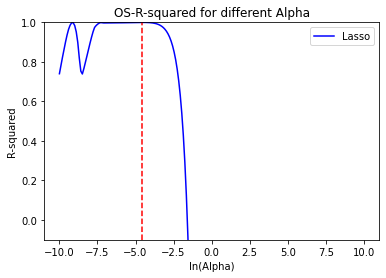

Optimal alpha for Lasso=0.010328333639342603, best OS R_2=0.9997005768186314


In [29]:
alphas = np.exp(np.linspace(-10,10,200)) #exponential range of possible alphas
[alpha_optimal, best_R2, best_coefs]=Regularization_fit_alpha(2,train_norm.iloc[:,1:],train_norm.y,valid_norm.iloc[:,1:],valid_norm.y,alphas,Graph=True,logl=True)
print('Optimal alpha for Lasso={0}, best OS R_2={1}'.format(alpha_optimal,best_R2))

In [30]:
Lasso=linear_model.Lasso(fit_intercept=True, alpha=alpha_optimal)
Lasso.fit(train_norm.iloc[:,1:],train_norm.y)
#Out of sample
YPred_OS=Lasso.predict(test_norm.iloc[:,1:])
print("The OS R-squared of Lasso is: {0}".format(r2_score(test_norm.y,YPred_OS)))
print("Lasso coef: ", Lasso.coef_)

The OS R-squared of Lasso is: 0.999959721517069
Lasso coef:  [0.23392368 0.24200002 0.44671657 0.60394017 0.         0.
 0.         0.         0.         0.        ]


<span style='font-size:18pt; color:red'>Original optimal alpha is 144.73064176460485, now it is 0.010328333639342603. Coef shows above</span>